In [1]:
import torch
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from networks import *

In [3]:
from data_loader.data_loaders import MnistDataLoader

In [4]:
code_size = 100 
code_gen = CodeGenerator(code_size, noise_size=code_size)
encoder = Encoder(code_size)
decoder = Decoder(code_size)
disc_code = CodeDiscriminator(code_size)
disc_img = ImageDiscriminator()

In [5]:
n_gpu_use = 1
device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')

encoder = encoder.to(device)
decoder = decoder.to(device)
code_gen = code_gen.to(device)
disc_code = disc_code.to(device)
disc_img = disc_img.to(device)

optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=10e-4)
optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=10e-4)
optimizer_disc_img = torch.optim.Adam(disc_img.parameters(), lr=10e-4)
optimizer_disc_code = torch.optim.Adam(disc_code.parameters(), lr=10e-4)
optimizer_code_gen = torch.optim.Adam(code_gen.parameters(), lr=10e-4)

optimizer_enc_gen = torch.optim.Adam(encoder.parameters(), lr=10e-4)

In [6]:
batch_size = 2*128
data_loader = MnistDataLoader('mnist_data', batch_size=batch_size, shuffle=True, validation_split=0.2, num_workers=1)

In [7]:
import torch, torchvision

traindataset = torchvision.datasets.MNIST('mnist_data', transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
data_loader = torch.utils.data.dataloader.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [11]:
arr_disc_loss

[2.6979880332946777,
 4.36767041683197,
 6.0605738162994385,
 7.701785445213318,
 9.248862743377686,
 10.70861303806305,
 12.100895404815674,
 13.450331091880798,
 14.774808883666992,
 16.070801734924316,
 17.331115007400513,
 18.543465971946716,
 19.707557201385498,
 20.82055139541626,
 21.87903070449829,
 22.873349845409393,
 23.797983467578888,
 24.6335272192955,
 25.390141904354095,
 26.0390585064888,
 26.59390413761139,
 27.044233590364456,
 27.412540525197983,
 27.709652692079544,
 27.93221989274025,
 28.14793500304222,
 28.285293012857437,
 28.398514941334724,
 28.48638841509819,
 28.542237505316734,
 28.5808429941535,
 28.606972709298134,
 28.627837788313627,
 28.841321852058172,
 28.854668272659183,
 28.869110728614032,
 28.881360851228237,
 28.89588122535497,
 28.911579188890755,
 28.926013155840337,
 28.937668663449585,
 28.95047313719988,
 28.965266639366746,
 28.98000569269061,
 28.990796210244298,
 29.00541123189032,
 29.02173489332199,
 29.03512816131115,
 29.04746192507

In [8]:
# optimizer_G = torch.optim.Adam([encoder.parameters(), decoder.parameters()])
# optimizer_D = torch.optim.Adam([disc_code.parameters(), disc_img.parameters()])

dec_weight = 2

cross_entropy_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss() 

eps = 1e-10

arr_ae_loss = []
arr_disc_loss = []
def train_epoch():
    rec_total_loss = 0
    disc_code_total_loss = 0
    gen_adv_total_loss = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        cur_batch_size = data.shape[0]

        data_repr = encoder(data)
        data_rec = decoder(data_repr)

        rec_loss = ((data_rec-data)**2).mean() #mse_loss(data_rec, data.detach())
        disc_code_pred_fake = disc_code(data_repr).reshape(cur_batch_size)
        gen_adv_loss = -torch.log(disc_code_pred_fake+eps).mean()
        
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        (rec_loss+0.001*gen_adv_loss).backward() 
        optimizer_enc.step()
        optimizer_dec.step()
        rec_total_loss += rec_loss.data.cpu().numpy().item()
        gen_adv_total_loss += gen_adv_loss.data.cpu().numpy().item()
        
        arr_ae_loss.append((rec_loss+0.001*gen_adv_loss).data.cpu().numpy().item())
        
        
        z_code = (5*torch.randn((cur_batch_size, code_size))).to(device)
        data_repr = encoder(data)
        disc_code_pred_fake = disc_code(data_repr).reshape(cur_batch_size)
        disc_code_pred_real = disc_code(z_code).reshape(cur_batch_size)
        disc_code_gan_loss = -2*(torch.log(disc_code_pred_real+eps) + torch.log(1-disc_code_pred_fake+eps)).mean()
        optimizer_disc_code.zero_grad()
        disc_code_gan_loss.backward()
        optimizer_disc_code.step()   
        disc_code_total_loss += disc_code_gan_loss.data.cpu().numpy().item()
        
        arr_disc_loss.append(disc_code_total_loss)
        
        
#         data_repr = encoder(data)
#         disc_code_pred_fake = disc_code(data_repr).reshape(cur_batch_size)
        
#         optimizer_enc_gen.zero_grad()
#         gen_adv_loss = -torch.log(disc_code_pred_fake+eps).mean()
#         gen_adv_loss.backward(retain_graph=False)
#         optimizer_enc_gen.zero_grad()
#         gen_adv_total_loss += gen_adv_loss.data.cpu().numpy().item()
        
    #clear_output(wait=True)
    plt.imshow(((data_rec[1].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
    plt.savefig('log_img/'+str(i)+'.png')
    plt.show()
    print("rec_total_loss:", rec_total_loss)
    print("disc_code_total_loss:", disc_code_total_loss)
    print("gen_adv_total_loss:", gen_adv_total_loss)
    print()
    plt.imshow(((decoder(z_code.unsqueeze(-1).unsqueeze(-1))[1].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
    plt.show()
    print()

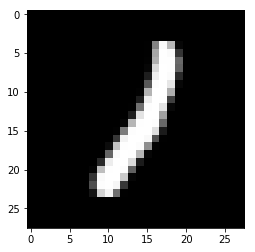

rec_total_loss: 2.0284659061580896
disc_code_total_loss: 103.14058332145214
gen_adv_total_loss: 1098.2972340583801



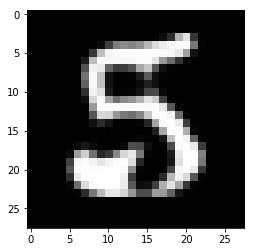


0


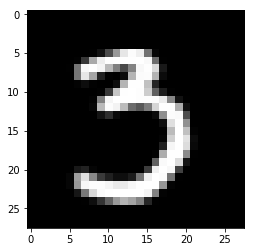

rec_total_loss: 2.078936413861811
disc_code_total_loss: 115.7606508731842
gen_adv_total_loss: 1094.6339020729065



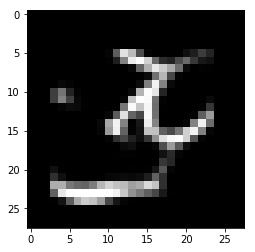


1


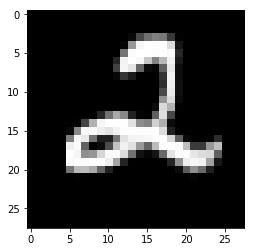

rec_total_loss: 2.058544047642499
disc_code_total_loss: 152.982416421175
gen_adv_total_loss: 998.6171288490295



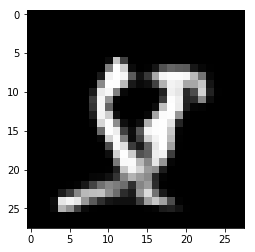


2


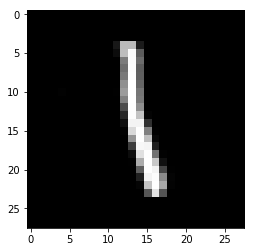

rec_total_loss: 2.0381938167847693
disc_code_total_loss: 171.2769599556923
gen_adv_total_loss: 957.5060427188873



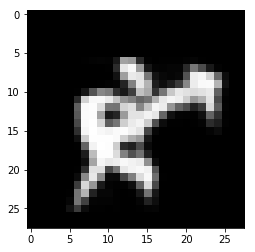


3


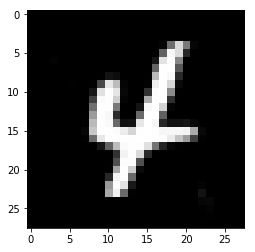

rec_total_loss: 2.1031053457409143
disc_code_total_loss: 188.5936729311943
gen_adv_total_loss: 902.6261610984802



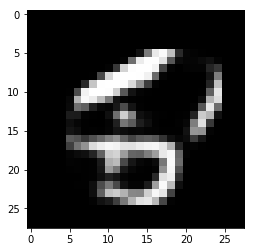


4


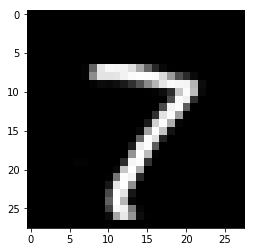

rec_total_loss: 2.049838569480926
disc_code_total_loss: 192.30057567358017
gen_adv_total_loss: 920.0914440155029



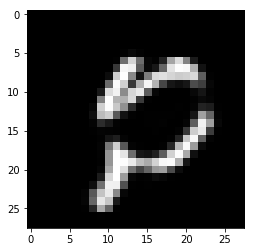


5


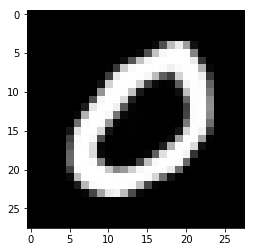

rec_total_loss: 1.9826726978644729
disc_code_total_loss: 204.23607563972473
gen_adv_total_loss: 840.7260529994965



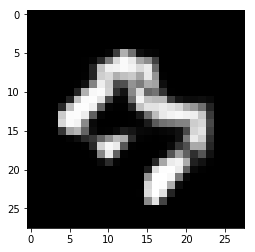


6


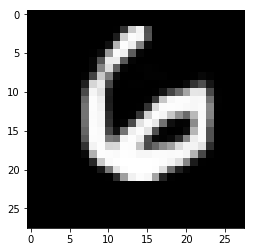

rec_total_loss: 1.9161892291158438
disc_code_total_loss: 210.94531601667404
gen_adv_total_loss: 810.7599995136261



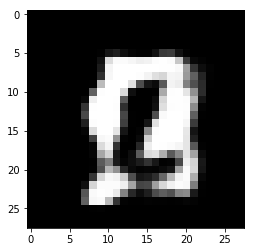


7


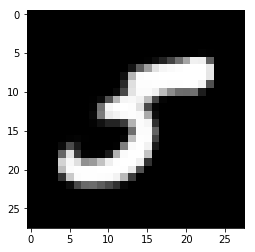

rec_total_loss: 1.9476071796379983
disc_code_total_loss: 213.47943848371506
gen_adv_total_loss: 823.755921125412



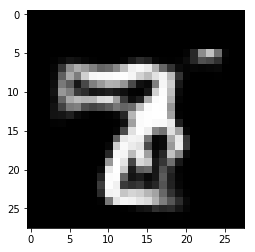


8


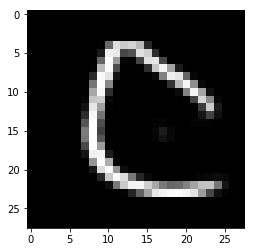

rec_total_loss: 1.9160281168296933
disc_code_total_loss: 229.25008016824722
gen_adv_total_loss: 756.9569849967957



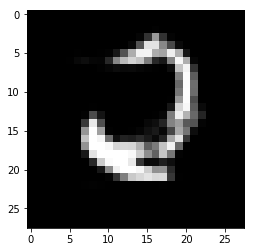


9


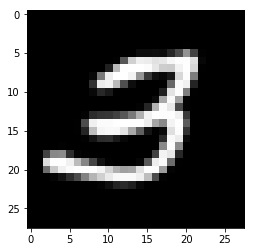

rec_total_loss: 1.8800260862335563
disc_code_total_loss: 228.77600705623627
gen_adv_total_loss: 791.5899465084076



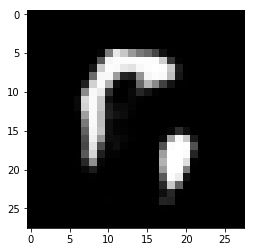


10


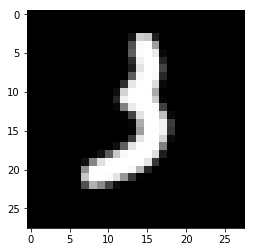

rec_total_loss: 1.9321474232710898
disc_code_total_loss: 238.37448835372925
gen_adv_total_loss: 770.9754056930542



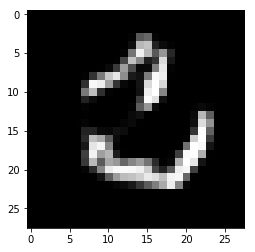


11


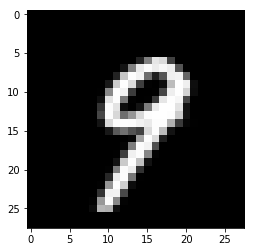

rec_total_loss: 1.9110470223240554
disc_code_total_loss: 245.72461879253387
gen_adv_total_loss: 767.8812367916107



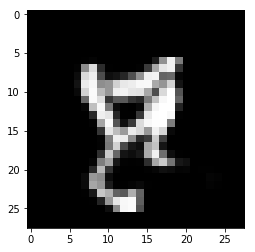


12


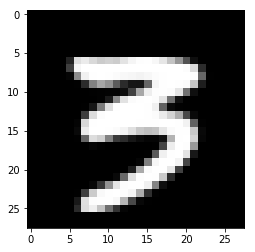

rec_total_loss: 1.9092879900708795
disc_code_total_loss: 252.69541555643082
gen_adv_total_loss: 747.1984379291534



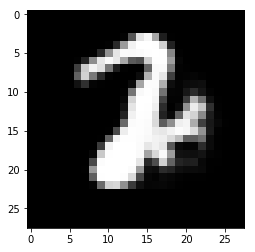


13


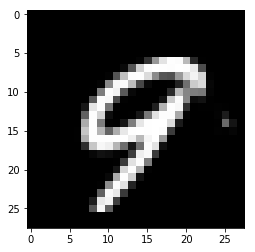

rec_total_loss: 1.8957564481534064
disc_code_total_loss: 256.80061864852905
gen_adv_total_loss: 741.6538009643555



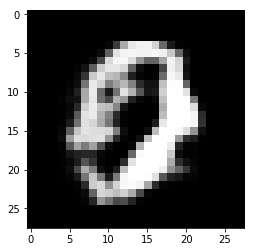


14


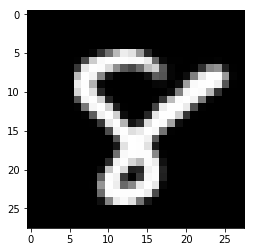

rec_total_loss: 1.9398343339562416
disc_code_total_loss: 264.1119365096092
gen_adv_total_loss: 743.4297904968262



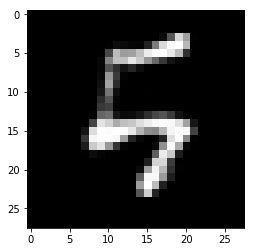


15


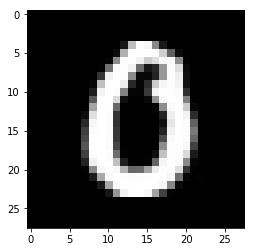

rec_total_loss: 1.9309434164315462
disc_code_total_loss: 260.4578434228897
gen_adv_total_loss: 734.1353213787079



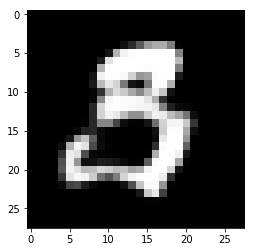


16


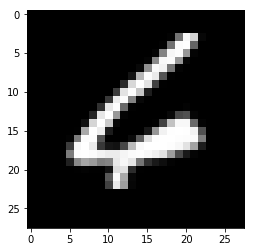

rec_total_loss: 1.8976581990718842
disc_code_total_loss: 263.6729778647423
gen_adv_total_loss: 737.6786544322968



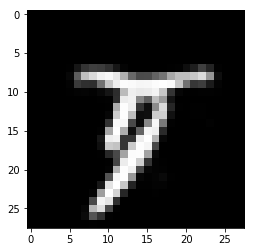


17


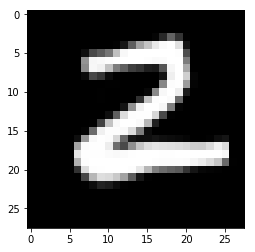

rec_total_loss: 1.9155941219069064
disc_code_total_loss: 263.32180219888687
gen_adv_total_loss: 722.1915507316589



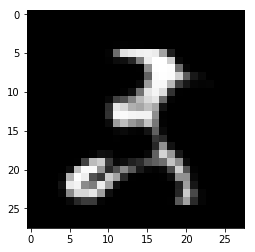


18


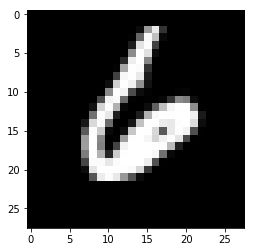

rec_total_loss: 1.9232916571199894
disc_code_total_loss: 271.9097245335579
gen_adv_total_loss: 716.9244692325592



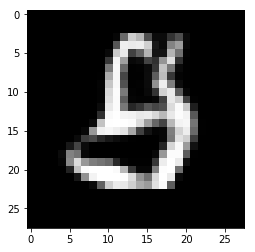


19


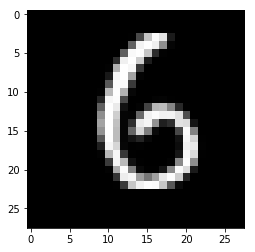

rec_total_loss: 1.8870036606676877
disc_code_total_loss: 253.25048118829727
gen_adv_total_loss: 746.4735100269318



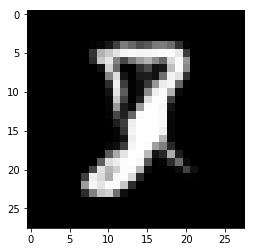


20


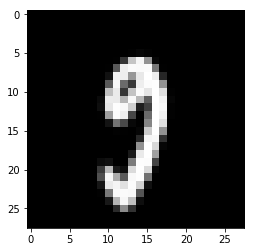

rec_total_loss: 1.9259893889538944
disc_code_total_loss: 251.54428112506866
gen_adv_total_loss: 752.9548153877258



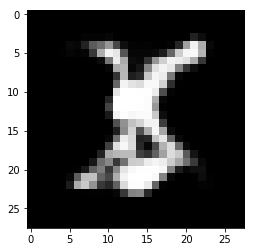


21


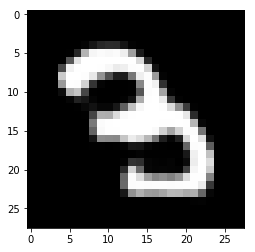

rec_total_loss: 1.9186587501317263
disc_code_total_loss: 242.86155551671982
gen_adv_total_loss: 772.1958465576172



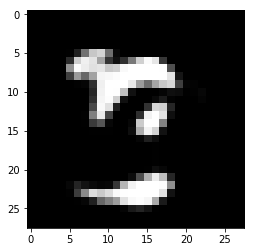


22


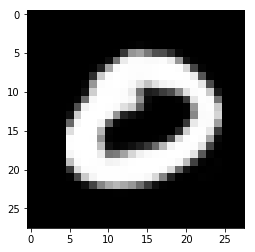

rec_total_loss: 1.9296404947526753
disc_code_total_loss: 240.26152884960175
gen_adv_total_loss: 795.0362577438354



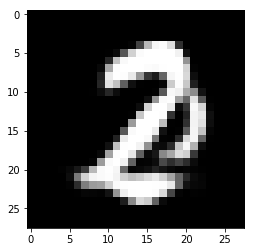


23


Process Process-838:
Process Process-833:
Process Process-840:
Process Process-839:
Process Process-834:
Process Process-837:
Process Process-836:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._a

KeyboardInterrupt: 

Process Process-835:
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk =

In [12]:
for i in range(100):
    train_epoch()
    torch.save(encoder, "encoder")
    torch.save(decoder, "decoder")
    torch.save(disc_code, "disc_code")
    print(i)

In [23]:
axes[4][9]

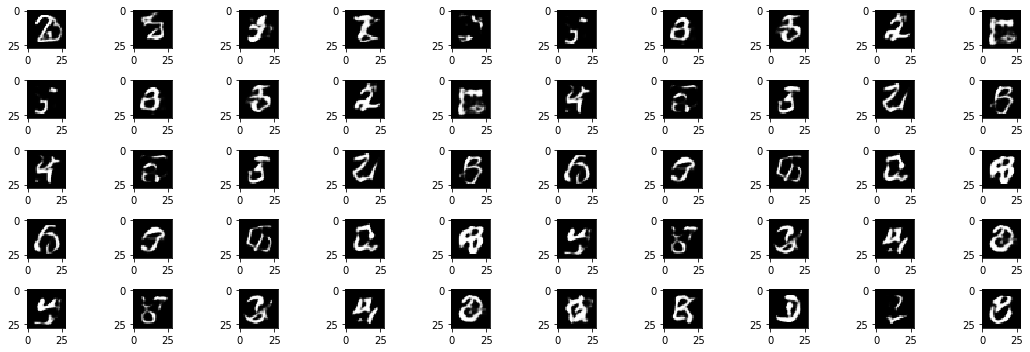

In [28]:
n_rows = 5
n_columns = 10
f, axes = plt.subplots(n_rows, n_columns, figsize=(15,5))
z_code = (5*torch.randn((n_rows*n_columns, code_size))).to(device)
data_samples = decoder(z_code.unsqueeze(-1).unsqueeze(-1))

for i in range(n_rows):
    for j in range(n_columns):
        axes[i][j].imshow(((data_samples[n_rows*i+j].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
f.tight_layout()

In [10]:
for x, y in data_loader:
    x_enc = encoder(x.cuda())
    break

In [16]:
decoder = decoder.to(device)

In [18]:
x_rec = decoder(x_enc[0].unsqueeze(0))

In [11]:
for x, y in data_loader:
    x_rec = decoder(encoder(x.cuda()))
    break

In [22]:
x[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

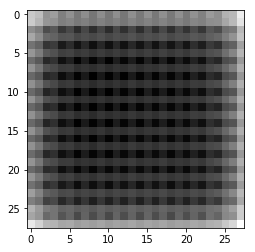

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(((x_rec[0].data.cpu().numpy()+1)/2).reshape(28, 28), cmap='gray')

In [16]:
x_rec[1].min()

tensor(-1., device='cuda:0')

In [65]:
x[1].data.cpu().numpy().reshape(28,28)

array([[-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.4242

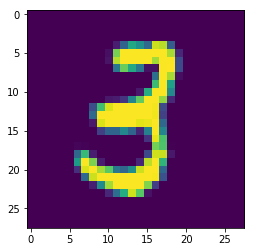

In [64]:
plt.imshow(x[1].data.cpu().numpy().reshape(28,28))

In [7]:


n_gpu_use = 1
device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')

encoder = encoder.to(device)
decoder = decoder.to(device)
code_gen = code_gen.to(device)
disc_code = disc_code.to(device)
disc_img = disc_img.to(device)

dec_weight = 2

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss() 


In [10]:
for batch_idx, (data, target) in enumerate(data_loader):
    data, target = data.to(device), target.to(device)

    # AAE phase
    z = torch.randn((batch_size, 8)).to(device)
    code_gen.train(False)
    disc_img.train(False)
    encoder.train()
    disc_code.train()
    decoder.train()

    z_code = code_gen(z)
    data_repr = encoder(data)
    data_rec = decoder(data_repr)
    loss_rec = mse_loss(disc_img(data_rec)[0], disc_img(data)[0].detach()) #.fmap
    disc_code_input = torch.cat((z_code, data_repr))
    disc_code_pred = disc_code(disc_code_input)
    disc_code_target = torch.cat((torch.ones(batch_size), torch.zeros(batch_size))).long().to(device)
    break 
    disc_code_gan_loss = cross_entropy_loss(disc_code_pred, disc_code_target)


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [12]:
cross_entropy_loss(disc_code_pred, disc_code_target)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:70

In [11]:
disc_img(data_rec)[0]

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]]], device='cuda:0')

In [13]:
cross_entropy_loss(disc_code_pred, disc_code_target.long())

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:70

In [14]:
loss_rec.backward()